# Session 2 : Introduction to Statistical Signal Processing

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This second session is dedicated to the description of basic notions in statistical signal processing such as basic statistics, autocorrelation function, Power Spectral Density (PSD) estimators and spectrogram. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Mean, variance and autocorrelation function**
4. **Power spectral density and spectrogram**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
mpl.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session2.npz')
x=npzfile['x']
t=npzfile['t']
Fs=1

# First investigations
N=np.size(x)
print("Number of samples : {N}".format(**locals()))
print("First mesurement : {}".format(t[0]))
print("Last mesurement : {}".format(t[-1]))

Number of samples : 192
First mesurement : 2004-01
Last mesurement : 2019-12


## 2. Exploratory study

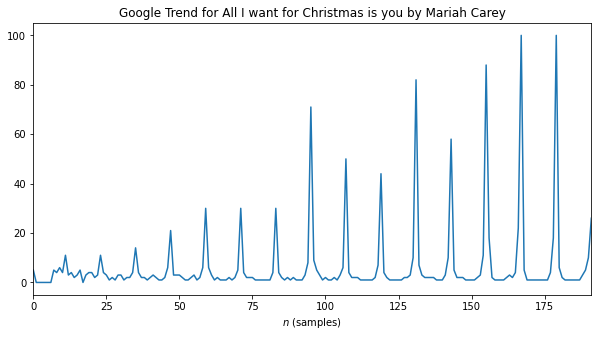

In [4]:
# x[n] as a function of the sample n
n=np.arange(N)
plt.plot(n,x)
plt.xlim((0,N-1))
plt.xlabel('$n$ (samples)')
plt.title('Google Trend for All I want for Christmas is you by Mariah Carey')
plt.show()

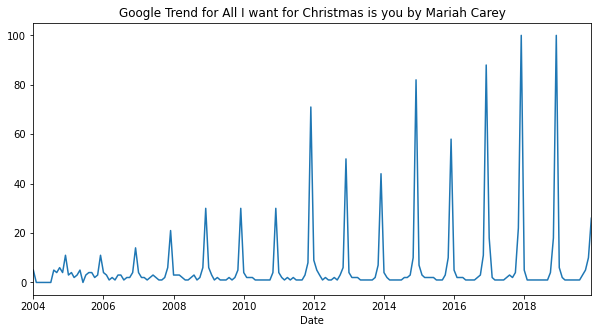

In [5]:
# x[n] as a function of the date
plt.plot(t,x)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.title('Google Trend for All I want for Christmas is you by Mariah Carey')
plt.show()

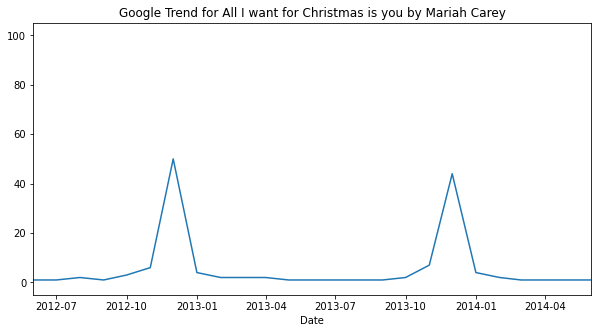

In [6]:
# x[n] as a function of the date (zoom)
plt.plot(t,x)
datemin = np.datetime64('2012-06', 'M')
datemax = np.datetime64('2014-06', 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.title('Google Trend for All I want for Christmas is you by Mariah Carey')
plt.show()

Here the signal appear to be periodic, with large values taken each year during the Holidays season

## 3. Mean, variance and autocorrelation function

Given a wide-sense stationary signal $x[n]$, several statistics can be empirically estimated:
* The mean $\mu$, estimated as
$$\hat{\mu} = \frac{1}{N} \sum_{n=0}^{N-1} x[n]$$
* The variance $\sigma^2$, estimated as
$$\hat{\sigma}^2 = \frac{1}{N} \sum_{n=0}^{N-1}  (x[n] - \hat{\mu})^2 \mbox{ (biased)}$$
$$\hat{\sigma}^2 = \frac{1}{N-1} \sum_{n=0}^{N-1}  (x[n] - \hat{\mu})^2 \mbox{ (unbiased)}$$
* The autocorrelation funtion  $\gamma_x[m]$, estimated as
$$\hat{\gamma}_x[m] = \frac{1}{N} \sum_{n=0}^{N-1} x[n]x[n+m]\mbox{ (biased)}\ \ \ \ \mbox{where } x[n]=0 \mbox{ for } n \neq 0\ldots N-1$$
$$\hat{\gamma}_x[m] = \frac{1}{N-|m|} \sum_{n=0}^{N-1} x[n]x[n+m]\mbox{ (unbiased)}\ \ \ \ \mbox{where } x[n]=0 \mbox{ for } n \neq 0\ldots N-1$$

In [7]:
mu=np.mean(x) #Mean
sigma2=np.var(x) #Variance (biased)
print("Empirical mean : {mu}".format(**locals()))
print("Empirical variance (biased) : {sigma2}".format(**locals()))

Empirical mean : 6.5
Empirical variance (biased) : 241.34375


In [8]:
# Biased estimator of the autocorrelation function
# lags are comprised between -maxLags and +maxLags
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

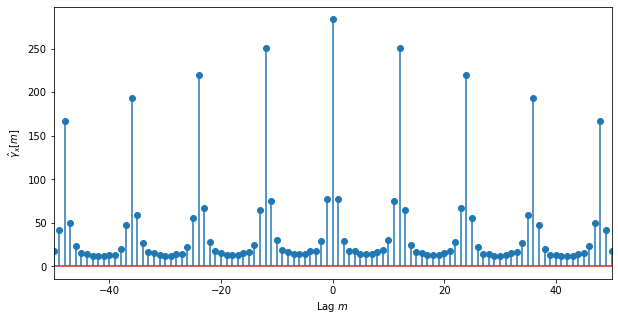

Largest value : 283.59375 for m=0
Second largest value : 250.21875 for m=12


In [9]:
# Plot the autocorrelation function
maxLags=50
gammax,lags=autocorrelation(x,maxLags)
plt.stem(lags,gammax,use_line_collection=True)
plt.xlabel('Lag $m$')
plt.xlim((-maxLags,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.show()

# Determination of the largest values
k=np.argsort(gammax)
print("Largest value : {} for m={}".format(gammax[k[-1]],lags[k[-1]]))
print("Second largest value : {} for m={}".format(gammax[k[-2]],lags[k[-2]]))

The peaks on the auto-correlation function give an overview of the periodicity properties of the signals : here a large peak is present at $m=12$, meaning that the signal tend to replicate each 12 months, i.e. each year

## 4. Power spectral density and spectrogram

Depending of the statistical properties of the signal of interest, several methods can be used to investigate the spectral properties repartition of power according to frequency.

* If the signal is stationary, its Power Spectral Density (PSD) $\Gamma_x[k]$ can be estimated as :
  $$\hat{\Gamma}^{corre}_x[k] = \mathcal{TFD} \left\lbrace \hat{\gamma}_x[m]\right\rbrace\ \ \ \ \mbox{correlogram}$$ 
    $$\hat{\Gamma}^{perio}_x[k] = \frac{1}{N} |X[k]|^2\ \ \ \ \mbox{periodogram}$$
* If the signal is not stationary, we can compute a spectrogram, which is a time-frequency representation where the spectral content is estimated frame by frame

### 4.1 Power Spectral Density

In [10]:
# Correlogram function
def correlogram(x,Fs):
    gammax,lags=autocorrelation(x,len(x)-1)
    gammax=np.pad(gammax[len(x)-1:],(0, 1),mode='constant')
    #Computation of the FFT
    Gammax=np.fft.hfft(gammax)
    Gammax=np.fft.fftshift(Gammax)
    # Computation the frequency vector
    N=len(Gammax)
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f

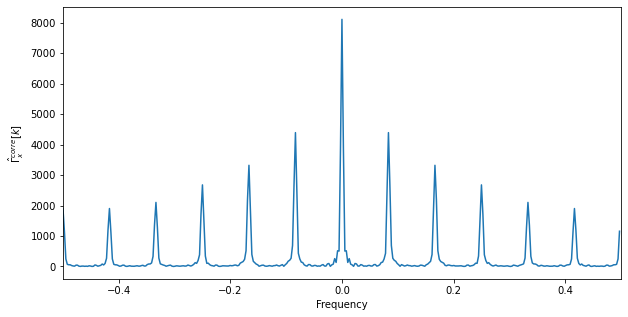

Largest value : 8112.0 for f=0.0
Second largest value : 4393.789081835109 for f=-0.08333333333333333
Remark : 1/12 = 0.08333333333333333


In [11]:
# Computation of the correlogram
Gammax,f=correlogram(x,Fs)
plt.plot(f,Gammax)
plt.ylabel('$\hat{\Gamma}^{corre}_x[k]$')
plt.xlabel('Frequency')
plt.xlim((-Fs/2,Fs/2))
plt.show()

# Determination of the largest values
k=np.argsort(Gammax)
print("Largest value : {} for f={}".format(Gammax[k[-1]],f[k[-1]]))
print("Second largest value : {} for f={}".format(Gammax[k[-2]],f[k[-2]]))
print("Remark : 1/12 = {}".format(1/12))

Here, a peak appears on the correlogram at frequency $f=0.08333$, which corresponds to $\frac{1}{12}$, hence giving a confirmation of the periodicity of the signal with $T = 12$

In [12]:
# Periodogram function
def periodogram(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f   

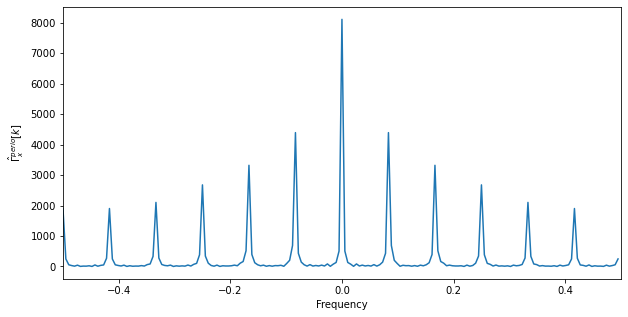

Largest value : 8112.0 for f=0.0
Second largest value : 4393.789081835108 for f=-0.08333333333333333
Remark : 1/12 = 0.08333333333333333


In [13]:
# Computation of the periodogram
Gammax,f=periodogram(x,Fs)
plt.plot(f,Gammax)
plt.ylabel('$\hat{\Gamma}^{perio}_x[k]$')
plt.xlabel('Frequency')
plt.xlim((-Fs/2,Fs/2))
plt.show()

# Determination of the largest values
k=np.argsort(Gammax)
print("Largest value : {} for f={}".format(Gammax[k[-1]],f[k[-1]]))
print("Second largest value : {} for f={}".format(Gammax[k[-2]],f[k[-2]]))
print("Remark : 1/12 = {}".format(1/12))

We observe the same phenomenon than for the correlogram

### 4.2 Spectrogram

In [14]:
def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,Sxx

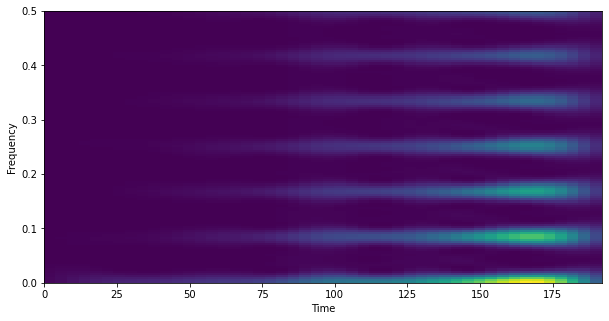

In [15]:
Nw=64 # Window length
No=60 # Overlap length
f, t, Sxx = my_spectrogram(x,Nw,No,Fs)
plt.pcolormesh(t, f, np.abs(Sxx)**2)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()               

Here, we can see the periodic properties of the signal that are present during the whole duration of the signal. The amplitude become larger after 100 months, which can also be observed from the raw data : there is a significant increase in popularity for this song after 2012.